Reference video: 
https://www.youtube.com/watch?v=Pf1lEv3b5s4&list=PL58zEckBH8fBW_XLPtIPlQ-mkSNNx0tLS&index=7

In [3]:
# Import necessary libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

### Training with Q Table

In [ ]:
def acrobot(name, is_training=True, render=False):
    env = gym.make(
        'Acrobot-v1', 
        render_mode='human' if render else None
    )
    
    # Divide obversion space into segments
    divisions = 15
    th1_cos = np.linspace(env.observation_space.low[0], env.observation_space.high[0], divisions)
    th1_sin = np.linspace(env.observation_space.low[1], env.observation_space.high[1], divisions)
    th2_cos = np.linspace(env.observation_space.low[2], env.observation_space.high[2], divisions)
    th2_sin = np.linspace(env.observation_space.low[3], env.observation_space.high[3], divisions)
    th1_w =   np.linspace(env.observation_space.low[4], env.observation_space.high[4], divisions)
    th2_w =   np.linspace(env.observation_space.low[5], env.observation_space.high[5], divisions)

    # Define Q Table
    if is_training:
        q = np.zeros((
            len(th1_cos) + 1, 
            len(th1_sin) + 1, 
            len(th2_cos) + 1, 
            len(th2_sin) + 1,
            len(th1_w) + 1,
            len(th2_w) + 1,
            env.action_space.n
        ))
    else:
        f = open(f'q_tables/q_{name}.pkl', 'rb')
        q = pkl.load(f)
        f.close()
    
    # Define the hyperparameters
    learning_rate_a = 0.1   # alpha or learning rate
    discount_factor_g = 0.9 # gamma or discount factor
    
    # Define policy parameters: we use the Epsilon Greedy Algorithm
    epsilon = 1                         # 1 = 100% random actions
    epsilon_decay_rate = 0.0005         # decay rate of epsilon
    epsilon_min = 0.05
    rng = np.random.default_rng()       # random number generator
    
    # Keep track of the rewards per episode
    best_reward = -999999
    rewards_per_episode = []
    
    # Keep track of the episodes
    i = 0
    
    # Iterate through all episodes
    while (True):
        state = env.reset()[0]  
        s_i0 = np.digitize(state[0], th1_cos)
        s_i1 = np.digitize(state[1], th1_sin)
        s_i2 = np.digitize(state[2], th2_cos)
        s_i3 = np.digitize(state[3], th2_sin)
        s_i4 = np.digitize(state[4], th1_w)
        s_i5 = np.digitize(state[5], th2_w)
        terminated = False      # True when the agent falls into a hole or reaches the goal    
        rewards = 0             # Rewards collected per episode
        
        while(not terminated):
            if is_training and rng.random() < epsilon:
                action = env.action_space.sample()  # Actions: 0-left, 1-right,
            else:
                action = np.argmax(q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5, :])
            
            new_state, reward, terminated, _, _ = env.step(action)
            
            ns_i0 = np.digitize(new_state[0], th1_cos)
            ns_i1 = np.digitize(new_state[1], th1_sin)
            ns_i2 = np.digitize(new_state[2], th2_cos)
            ns_i3 = np.digitize(new_state[3], th2_sin)
            ns_i4 = np.digitize(new_state[4], th1_w)
            ns_i5 = np.digitize(new_state[4], th2_w)
            
            # Apply the Q Learning formula after taking a step
            if is_training:
                q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5, action] = q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5, action] + learning_rate_a * (
                    reward + discount_factor_g * np.max(q[ns_i0, ns_i1, ns_i2, ns_i3, ns_i4, ns_i5, :]) - q[s_i0, s_i1, s_i2, s_i3, s_i4, s_i5, action]
                )
            
            state = new_state
            s_i0 = ns_i0
            s_i1 = ns_i1
            s_i2 = ns_i2
            s_i3 = ns_i3
            s_i4 = ns_i4
            s_i5 = ns_i5
            rewards += reward
            
        if not is_training and rewards%100 == 0:
            print(f'Accumulated rewards: {rewards}')
        
        if is_training and rewards > best_reward:
            best_reward = rewards
            
            # Save the Q Table
            f = open(f'q_tables/q_{name}.pkl', 'wb')
            pkl.dump(q, f)
            f.close()  
        
        # Append rewards per episode and calculate mean reward for last 100 episodes
        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])
        
        # Print some information every 100 episodes
        if is_training and i%100 == 0:
            print(f'Episode {i} rewards: {rewards}, Epsilon: {epsilon:0.2f}, Mean Rewards: {mean_rewards:0.1f}')
        
        # Stop training
        if best_reward > env.spec.reward_threshold:
            break
        
        # Decrease epsilon after each episode until it reaches 0
        epsilon = max(epsilon - epsilon_decay_rate, epsilon_min)  
        
        # Update i to keep track of the episode number
        i += 1
    
    # Close the environment
    env.close()
    
    # Plot the rewards per episode graph
    if render == False:
        mean_rewards = []
        for t in range(i):
            mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
        plt.xlabel('Iterations')
        plt.ylabel('Mean Rewards')
        plt.plot(mean_rewards)
    
    if is_training:
        print('Training completed!')

Episode 0 rewards: -771.0, Epsilon: 1.00, Mean Rewards: -771.0
Episode 100 rewards: -2046.0, Epsilon: 0.95, Mean Rewards: -1827.3
Episode 200 rewards: -1336.0, Epsilon: 0.90, Mean Rewards: -1679.2
Episode 300 rewards: -799.0, Epsilon: 0.85, Mean Rewards: -1383.0
Episode 400 rewards: -2135.0, Epsilon: 0.80, Mean Rewards: -1131.5
Episode 500 rewards: -835.0, Epsilon: 0.75, Mean Rewards: -1033.2
Episode 600 rewards: -1081.0, Epsilon: 0.70, Mean Rewards: -880.8
Episode 700 rewards: -441.0, Epsilon: 0.65, Mean Rewards: -784.5
Episode 800 rewards: -692.0, Epsilon: 0.60, Mean Rewards: -702.8
Episode 900 rewards: -430.0, Epsilon: 0.55, Mean Rewards: -665.0
Episode 1000 rewards: -529.0, Epsilon: 0.50, Mean Rewards: -614.7
Episode 1100 rewards: -517.0, Epsilon: 0.45, Mean Rewards: -578.8
Episode 1200 rewards: -384.0, Epsilon: 0.40, Mean Rewards: -542.4
Episode 1300 rewards: -1539.0, Epsilon: 0.35, Mean Rewards: -504.4
Episode 1400 rewards: -357.0, Epsilon: 0.30, Mean Rewards: -504.5
Episode 1500

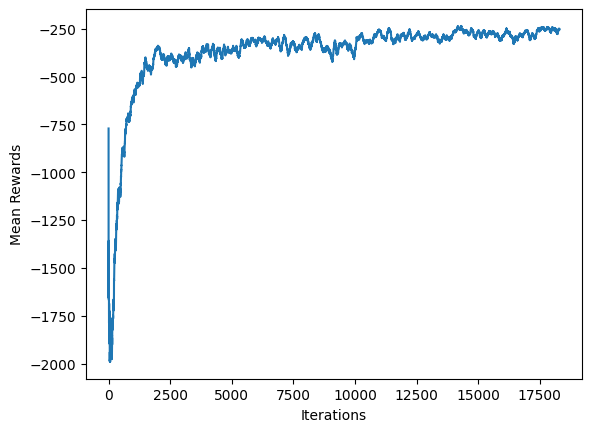

In [8]:
# Train
name = 'acrobot'
acrobot(name)

In [ ]:
# Watch the trained agent
acrobot(name, is_training=False, render=True)